# Generating gaits

The next step in developing the robot kinematics is to generate various gaits. First, lets familiarize ourselves with the concept of gaits. Gait is a coordinated sequence of movements of the robot legs and body to achieve smooth locomotion.

The two most common gaits are the tripod gait and the ripple gait. The tripod gait is a simple gait where the robot moves one leg at a time, while the ripple gait is a more complex gait where the legs move in a wave-like motion.

To get an idea of the variance and complexity between gaits, Fig 1. shows four typical gaits. The six legs, right and left hind, middle and front, indicated as RH, RM, RF, LH, LM, and LF, at any one time are either on the ground pushing forward (supporting) shown in white, or in the air moving up to their next position (recovering) shown in black. [borrowed from hexapodrobot.weebly.com](https://hexapodrobot.weebly.com/the-legs.html)

<div>
<img src="hexapod_gaits.png" width="600"/>
</div>

Fig 1. Four typical hexapodal gaits, depicting each of the six legs as either supporting (white) or recovering (black). Image source: (Chen et al. 2012)



## Tripod gait, one leg at a time

The tripod gait is a simple gait where the robot moves one leg at a time. The robot moves one leg forward, then the other leg forward, then the third leg forward. This is repeated until the robot has moved all three legs forward.

Parametrization of the tripod gait is done by specifying the following parameters:

  1. Leg swing angle
  2. Leg stance angle
  3. Leg lift angle
  4. Leg lift time
  5. Leg swing time
  6. Leg stance time

As before, we are going to start with simple 2D plots to build intuition via simple visualizations.

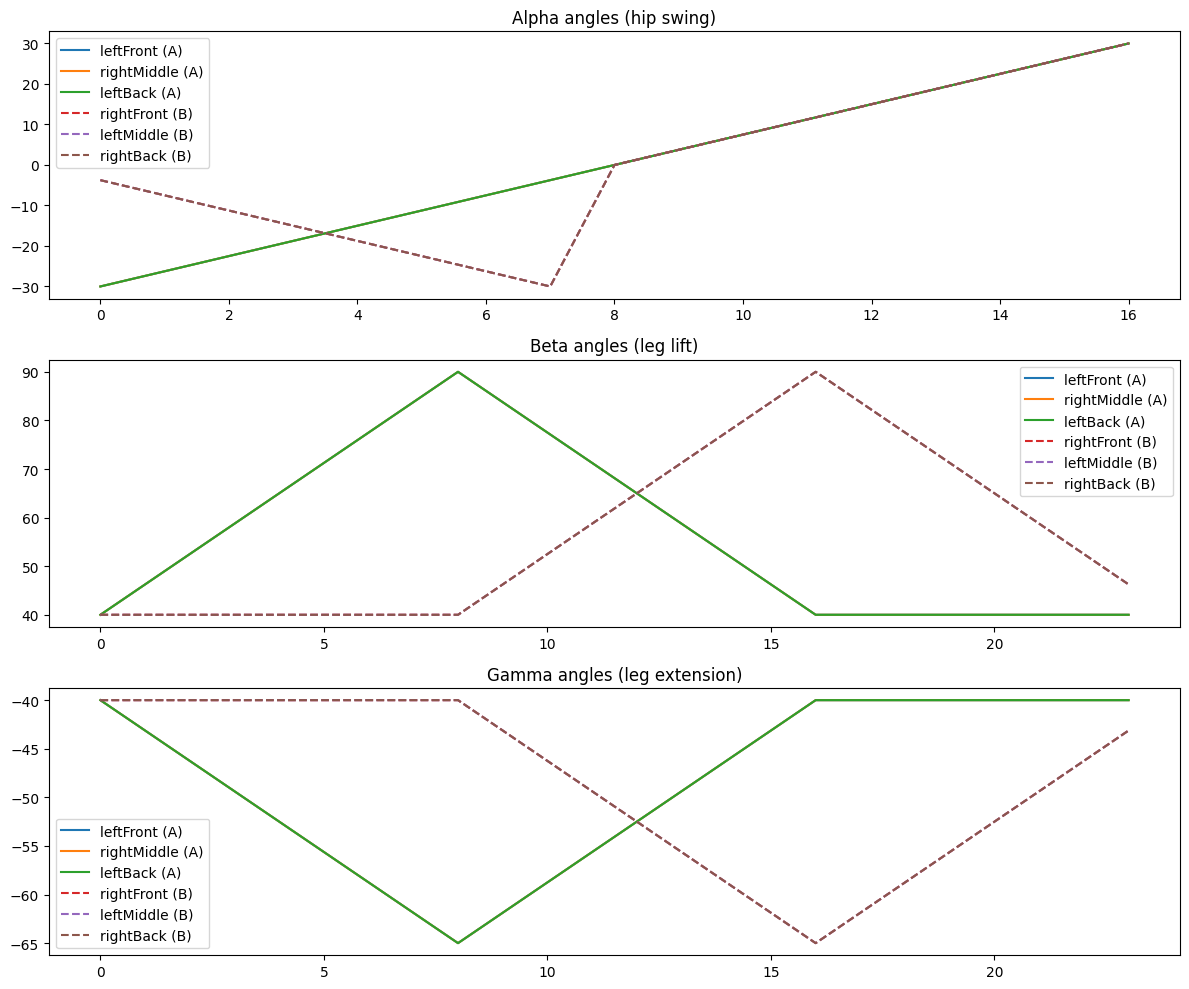

Pose at step 5: {'leftFront': {'alpha': -11.25, 'beta': 71.25, 'gamma': -55.625}, 'rightMiddle': {'alpha': -11.25, 'beta': 71.25, 'gamma': -55.625}, 'leftBack': {'alpha': -11.25, 'beta': 71.25, 'gamma': -55.625}, 'rightFront': {'alpha': -22.5, 'beta': 40.0, 'gamma': -40.0}, 'leftMiddle': {'alpha': -22.5, 'beta': 40.0, 'gamma': -40.0}, 'rightBack': {'alpha': -22.5, 'beta': 40.0, 'gamma': -40.0}}


In [1]:
import numpy as np
import matplotlib.pyplot as plt


class TripodGaitGenerator:
    def __init__(self, dimensions, params=None):
        """
        Tripod gait generator for 18DOF hexapod (6 legs, 3 DOF per leg).

        Args:
            dimensions: Dictionary with robot dimensions
            params: Dictionary with gait parameters

        """
        self.dimensions = dimensions
        self.params = params or {
            'tx': 0,  # Translation in x
            'tz': 0,  # Translation in z
            'rx': 0,  # Rotation around x
            'ry': 0,  # Rotation around y
            'legStance': 40,  # Default leg stance angle
            'hipStance': 25,  # Default hip stance angle
            'hipSwing': 30,  # Hip swing amplitude
            'liftSwing': 50,  # Leg lift amplitude
            'stepCount': 8,  # Number of steps in sequence
        }

        # Define leg groups for tripod gait
        self.tripod_a = ['leftFront', 'rightMiddle', 'leftBack']
        self.tripod_b = ['rightFront', 'leftMiddle', 'rightBack']

    def generate_sequence(self):
        """Generate the full tripod gait sequence."""
        # Calculate double step count
        double_step_count = 2 * self.params['stepCount']

        # Generate sequences for each leg
        sequences = {}

        # Generate tripod A sequences (first half of cycle in air)
        for leg in self.tripod_a:
            alpha_forward = self._build_sequence(
                -self.params['hipSwing'], 2 * self.params['hipSwing'], double_step_count
            )

            beta_lift = self._build_sequence(
                self.params['legStance'], self.params['liftSwing'], self.params['stepCount']
            )

            gamma_lift = self._build_sequence(
                -self.params['legStance'], -self.params['liftSwing'] / 2, self.params['stepCount']
            )

            # First half: leg lifts and moves forward, second half: on ground moving backward
            sequences[leg] = {
                'alpha': alpha_forward,
                'beta': self._combine_sequences(beta_lift, self.params['stepCount']),
                'gamma': self._combine_sequences(gamma_lift, self.params['stepCount']),
            }

        # Generate tripod B sequences (second half of cycle in air)
        for leg in self.tripod_b:
            alpha_forward = self._build_sequence(
                -self.params['hipSwing'], 2 * self.params['hipSwing'], double_step_count
            )

            beta_lift = self._build_sequence(
                self.params['legStance'], self.params['liftSwing'], self.params['stepCount']
            )

            gamma_lift = self._build_sequence(
                -self.params['legStance'], -self.params['liftSwing'] / 2, self.params['stepCount']
            )

            # First half: on ground moving backward, second half: leg lifts and moves forward
            sequences[leg] = {
                'alpha': list(reversed(alpha_forward[: double_step_count // 2]))
                + alpha_forward[double_step_count // 2 :],
                'beta': self._combine_sequences(
                    beta_lift, self.params['stepCount'], second_half=True
                ),
                'gamma': self._combine_sequences(
                    gamma_lift, self.params['stepCount'], second_half=True
                ),
            }

        return sequences

    def _build_sequence(self, start_value, delta, steps):
        """Build a linear sequence from start_value to start_value + delta in steps steps."""
        return [start_value + delta * i / steps for i in range(steps + 1)]

    def _combine_sequences(self, lift_seq, step_count, second_half=False):
        """Combine lift sequence with ground sequence."""
        # Create the neutral value (when leg is on ground)
        neutral_value = lift_seq[0]
        neutral_seq = [neutral_value] * step_count

        # Create the lift sequence (up and down)
        full_lift_seq = lift_seq + list(reversed(lift_seq[1:-1]))

        if second_half:
            # For tripod B: first half on ground, second half in air
            return neutral_seq + full_lift_seq
        else:
            # For tripod A: first half in air, second half on ground
            return full_lift_seq + neutral_seq

    def visualize(self, sequences=None):
        """Visualize the gait sequence."""
        if sequences is None:
            sequences = self.generate_sequence()

        fig, axs = plt.subplots(3, 1, figsize=(12, 10))

        # Plot alpha angles
        for leg, data in sequences.items():
            if leg in self.tripod_a:
                axs[0].plot(data['alpha'], label=f'{leg} (A)', linestyle='-')
            else:
                axs[0].plot(data['alpha'], label=f'{leg} (B)', linestyle='--')
        axs[0].set_title('Alpha angles (hip swing)')
        axs[0].legend()

        # Plot beta angles
        for leg, data in sequences.items():
            if leg in self.tripod_a:
                axs[1].plot(data['beta'], label=f'{leg} (A)', linestyle='-')
            else:
                axs[1].plot(data['beta'], label=f'{leg} (B)', linestyle='--')
        axs[1].set_title('Beta angles (leg lift)')
        axs[1].legend()

        # Plot gamma angles
        for leg, data in sequences.items():
            if leg in self.tripod_a:
                axs[2].plot(data['gamma'], label=f'{leg} (A)', linestyle='-')
            else:
                axs[2].plot(data['gamma'], label=f'{leg} (B)', linestyle='--')
        axs[2].set_title('Gamma angles (leg extension)')
        axs[2].legend()

        plt.tight_layout()
        plt.show()

    def get_pose_at_step(self, sequences, step):
        """Get the pose at a specific step in the sequence."""
        pose = {}
        for leg_position in sequences.keys():
            pose[leg_position] = {
                'alpha': sequences[leg_position]['alpha'][step],
                'beta': sequences[leg_position]['beta'][step],
                'gamma': sequences[leg_position]['gamma'][step],
            }
        return pose


# Example usage

dimensions = {
    'front': 100,
    'side': 100,
    'middle': 100,
    'coxa': 100,
    'femur': 100,
    'tibia': 100,
}

# Create generator with default parameters
generator = TripodGaitGenerator(dimensions)

# Generate sequence
sequences = generator.generate_sequence()

# Visualize the sequence
generator.visualize(sequences)

# Get pose at step 5
pose_at_step_5 = generator.get_pose_at_step(sequences, 5)
print('Pose at step 5:', pose_at_step_5)


This tripod gait generator:

 1. Creates sequences for all 6 legs divided into two tripod groups
 2. Generates coordinated movement patterns where:
    - Tripod A (leftFront, rightMiddle, leftBack) moves in the first half of the cycle
    - Tripod B (rightFront, leftMiddle, rightBack) moves in the second half
    - When one tripod is lifting and moving forward, the other is on the ground providing support
 3. Provides visualization to help understand the gait pattern
 4. Allows you to extract the pose at any step in the sequence
 
The implementation is based on your existing code structure but simplified for clarity. You can adjust parameters like hipSwing, liftSwing, and stepCount to modify the gait characteristics.

